In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [66]:
df =  pd.read_csv('Reviews.csv')
column_names = df.columns
print(column_names)

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


In [67]:
df = df.drop(columns=['Price', 'User_id','profileName', 'review/helpfulness','review/time', 'review/text'])
column_names = df.columns
print(column_names)
print(df.shape)

Index(['Id', 'Title', 'review/score', 'review/summary'], dtype='object')
(3000000, 4)


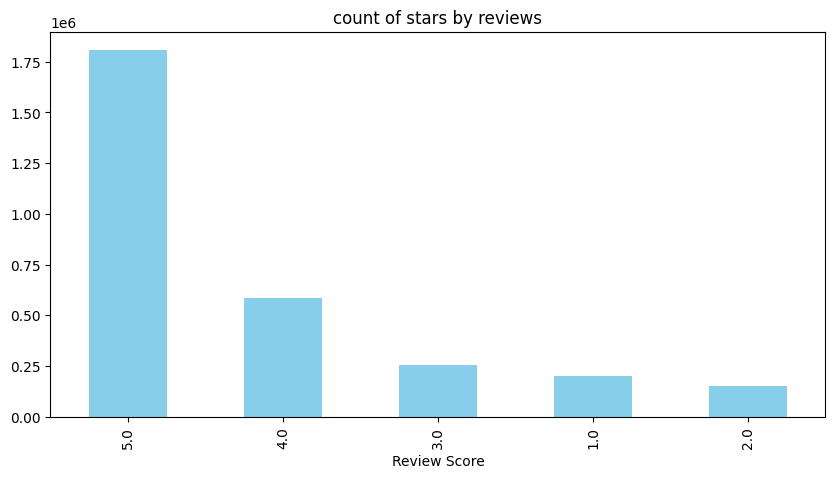

In [68]:
grph  = df['review/score'].value_counts().plot(kind='bar',title='count of stars by reviews', figsize=(10, 5), color='skyblue')
plt.xlabel('Review Score')
plt.show()

In [69]:
sia = SentimentIntensityAnalyzer()

In [75]:
df = df.iloc[:100000].reset_index(drop=True)
df = df[df['review/summary'].apply(lambda x: isinstance(x, str))].copy()
print(df.shape)

(99982, 8)


In [76]:
for i in tqdm(range(len(df))):
    scores = sia.polarity_scores(df.loc[i, 'review/summary'])
    df.loc[i, 'positive'] = scores['pos']
    df.loc[i, 'negative'] = scores['neg']
    df.loc[i, 'neutral'] = scores['neu']
    df.loc[i, 'compound'] = scores['compound']
df.head()

  0%|          | 0/99982 [00:00<?, ?it/s]

,Id,Title,review/score,review/summary,positive,negative,neutral,compound
0,1882931173,Its Only Art If Its Well Hung!,4.0,Nice collection of Julie Strain images,0.350,0.150,0.500,0.3818
1,0826414346,Dr. Seuss: American Icon,5.0,Really Enjoyed It,0.642,0.000,0.358,0.5563
2,0826414346,Dr. Seuss: American Icon,5.0,Essential for every personal and Public Library,0.000,0.000,1.000,0.0000
3,0826414346,Dr. Seuss: American Icon,4.0,Phlip Nel gives silly Seuss a serious treatment,0.149,0.176,0.676,-0.0516
4,0826414346,Dr. Seuss: American Icon,4.0,Good academic overview,0.592,0.000,0.408,0.4404


<br><br>
# Observations:

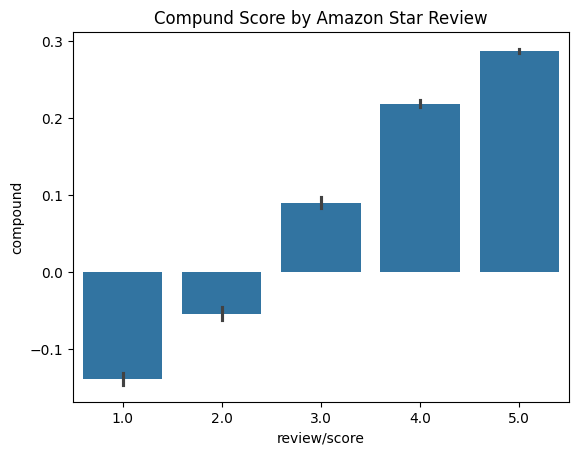

In [77]:
ax = sns.barplot(data=df, x='review/score', y='compound',)
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

- 1 star & 2 star reviews show negative sentiment (2 star slightly more negative).

- 3 star reviews are mostly neutral with mixed sentiment.

- 4 star & 5 star reviews have strong positive sentiment (5 star most consistent).

- Variation is higher in mid/low ratings, lowest in 5 star reviews.

In [78]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [79]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [80]:
encoded_text = tokenizer("this is an example text", return_tensors='pt')
print(encoded_text)

{'input_ids': tensor([[   0, 9226,   16,   41, 1246, 2788,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


#### the tokenizer returns a tensor which the model doesnt understand so we're goint to conver it to numpy
## Comparing VADER and  RoBERTa Pretrained Model

In [81]:
example = df['review/summary'].iloc[4]
print("Example text = ",example)
sia.polarity_scores(example)

Example text =  Good academic overview


{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

In [82]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.012228954), 'roberta_neu': np.float32(0.2429189), 'roberta_pos': np.float32(0.7448521)}


Example text =  Good academic overview

| Model         | Positive   | Negative     | Neutral   |
|---------------|------------|--------------|-----------|
| Roberta Model | 0.7448521  | 0.012228954  | 0.2429189 |
| VADER         | 0.592      | 0.0          | 0.408     |

clearly the roberta model is performing better 

In [ ]:
for i in tqdm(range(len(df))):
    encoded = tokenizer(df.loc[i, 'review/summary'], return_tensors='pt', truncation=True)
    output = model(**encoded)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    df.loc[i, 'roberta_neg'] = scores[0]
    df.loc[i, 'roberta_neu'] = scores[1]
    df.loc[i, 'roberta_pos'] = scores[2]


In [84]:
df.to_csv('after_wheighing.csv', index=False)


In [ ]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df['positive'], label='VADER Positive', color='blue', fill=True)
sns.kdeplot(df['roberta_pos'], label='RoBERTa Positive', color='orange', fill=True)

plt.title('Distribution of Positive Scores')
plt.xlabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
fina_df = pd.read_csv('after_wheighing.csv')
column_names = fina_df.columns
print(column_names)

Index(['Id', 'Title', 'review/score', 'review/summary', 'positive', 'negative',
       'neutral', 'compound', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')


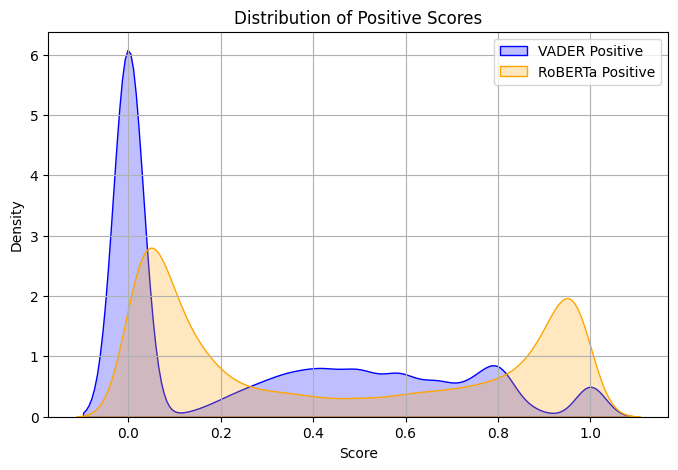

In [23]:
plt.figure(figsize=(8, 5))

sns.kdeplot(fina_df['positive'], label='VADER Positive', color='blue', fill=True)
sns.kdeplot(fina_df['roberta_pos'], label='RoBERTa Positive', color='orange', fill=True)

plt.title('Distribution of Positive Scores')
plt.xlabel('Score')
plt.legend()
plt.grid(True)
plt.show()

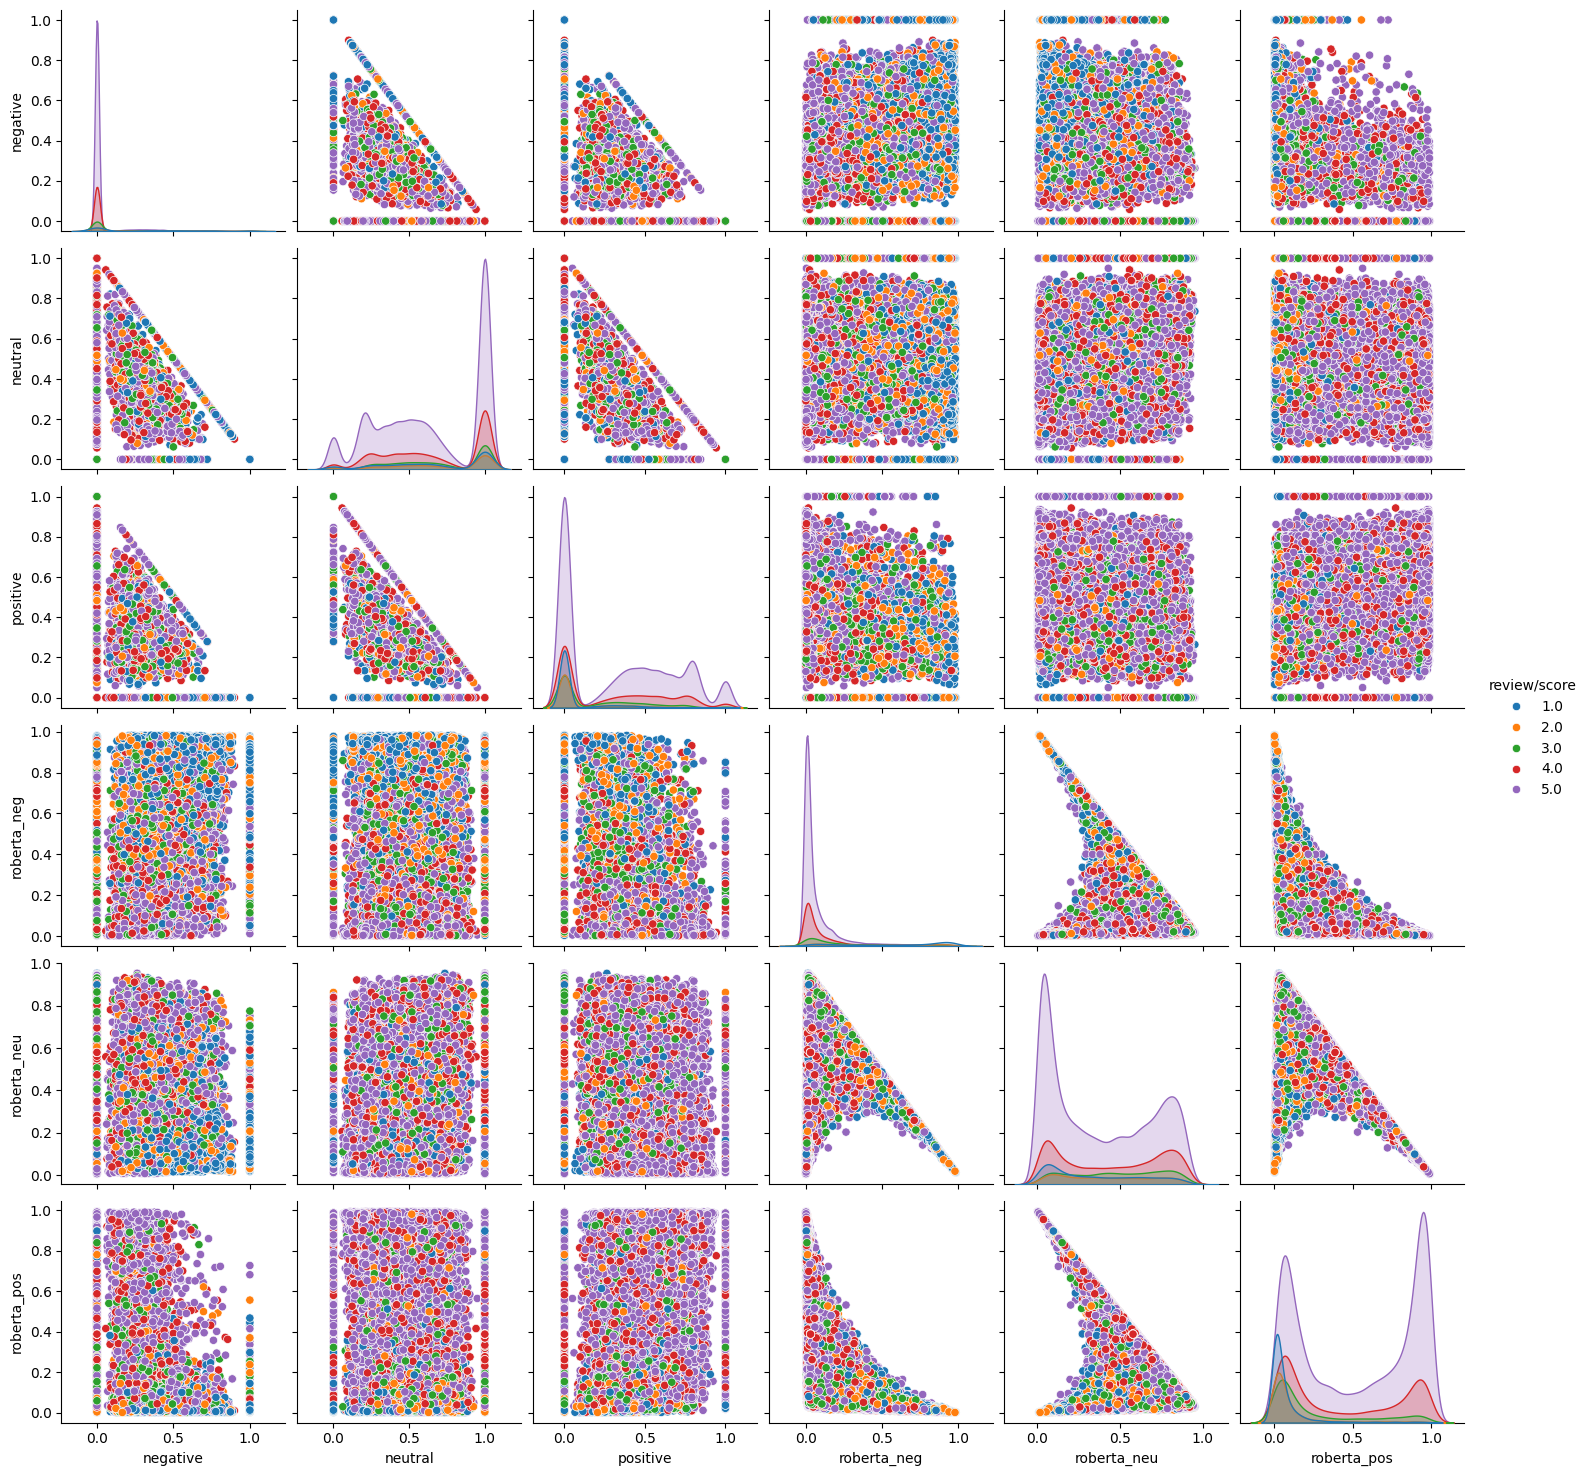

In [24]:
sns.pairplot(data=fina_df,
             vars=['negative', 'neutral', 'positive',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='review/score',
            palette='tab10')
plt.show()

# Pre Processing for the Neural Net Model

In [11]:
fina_df['sentiment_flag'] = fina_df['compound'].apply(lambda x: 1 if x >= 0 else 0)


In [90]:
df_small = fina_df.copy()
df_small.shape
#df_small.head()

(99982, 12)

In [91]:
from sklearn.model_selection import train_test_split
#import tensorflow as tf


In [92]:
X = df_small['review/summary'] 
y = df_small['sentiment_flag']   

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [61]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [93]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

In [94]:
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [95]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

22629

In [96]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [97]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [98]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [99]:
embedding_matrix.shape

(22629, 100)

## Model I (Dense + Flatten)

In [100]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix] , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [101]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │     2,262,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,262,900 (8.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,262,900 (8.63 MB)

None


In [102]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.8726 - loss: 0.3845 - val_acc: 0.8893 - val_loss: 0.2913
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8903 - loss: 0.2837 - val_acc: 0.8949 - val_loss: 0.2680
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8952 - loss: 0.2647 - val_acc: 0.9005 - val_loss: 0.2586
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8996 - loss: 0.2551 - val_acc: 0.9009 - val_loss: 0.2530
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9040 - loss: 0.2451 - val_acc: 0.9007 - val_loss: 0.2489
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9046 - loss: 0.2409 - val_acc: 0.9020 - val_loss: 0.2465


In [103]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8985 - loss: 0.2558


In [104]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.25316503643989563
Test Accuracy: 0.9008851051330566


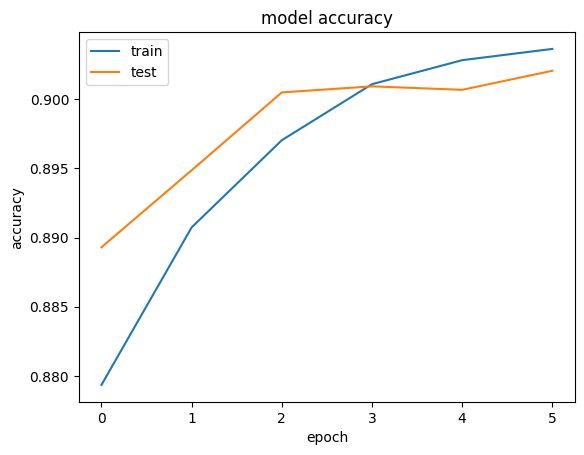

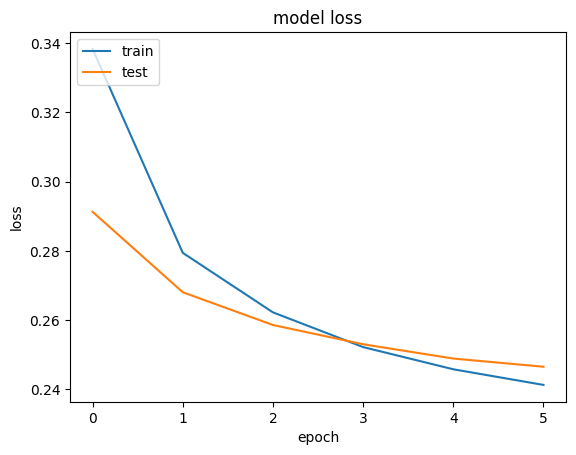

In [105]:
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Model III (CNN)

In [106]:
from keras.layers import Conv1D

In [107]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix] , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [108]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     2,262,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,262,900 (8.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,262,900 (8.63 MB)

None


In [109]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - acc: 0.8823 - loss: 0.3099 - val_acc: 0.9255 - val_loss: 0.1877
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - acc: 0.9311 - loss: 0.1731 - val_acc: 0.9325 - val_loss: 0.1683
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - acc: 0.9458 - loss: 0.1376 - val_acc: 0.9306 - val_loss: 0.1752
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - acc: 0.9556 - loss: 0.1159 - val_acc: 0.9407 - val_loss: 0.1560
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - acc: 0.9669 - loss: 0.0912 - val_acc: 0.9402 - val_loss: 0.1580
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - acc: 0.9725 - loss: 0.0775 - val_acc: 0.9446 - val_loss: 0.1506


In [110]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.9384 - loss: 0.1632


In [112]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.16103556752204895
Test Accuracy: 0.9400910139083862


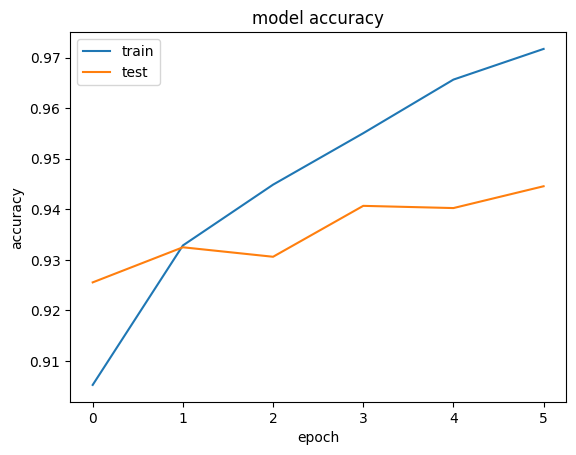

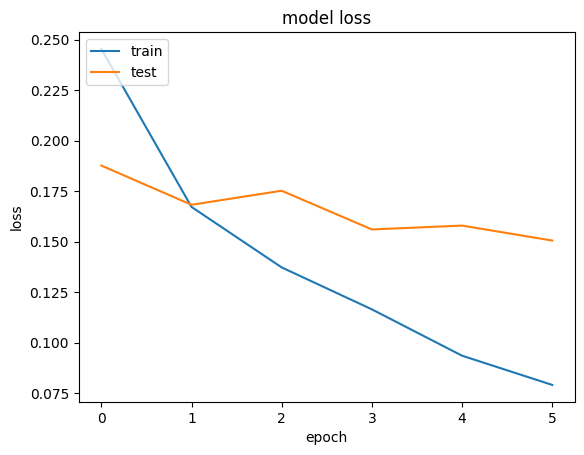

In [113]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Model III (LSTM)

In [114]:
from keras.layers import LSTM

In [115]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

c:\Users\amanr\OneDrive\Desktop\Ml project\mlenv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [116]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │     2,262,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,262,900 (8.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,262,900 (8.63 MB)

None


In [117]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 115s 226ms/step - acc: 0.8702 - loss: 0.3350 - val_acc: 0.9079 - val_loss: 0.2274
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 104s 208ms/step - acc: 0.8791 - loss: 0.3042 - val_acc: 0.8835 - val_loss: 0.2961
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 119ms/step - acc: 0.8803 - loss: 0.3213 - val_acc: 0.8835 - val_loss: 0.3447
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - acc: 0.8808 - loss: 0.3490 - val_acc: 0.8835 - val_loss: 0.3455
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - acc: 0.8809 - loss: 0.3495 - val_acc: 0.8835 - val_loss: 0.3444
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 174ms/step - acc: 0.8806 - loss: 0.3517 - val_acc: 0.8835 - val_loss: 0.3484


In [118]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - acc: 0.8794 - loss: 0.3560


In [119]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.35456788539886475
Test Accuracy: 0.8804820775985718


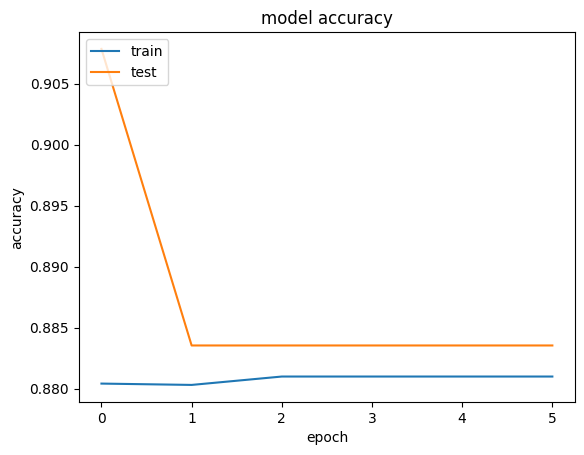

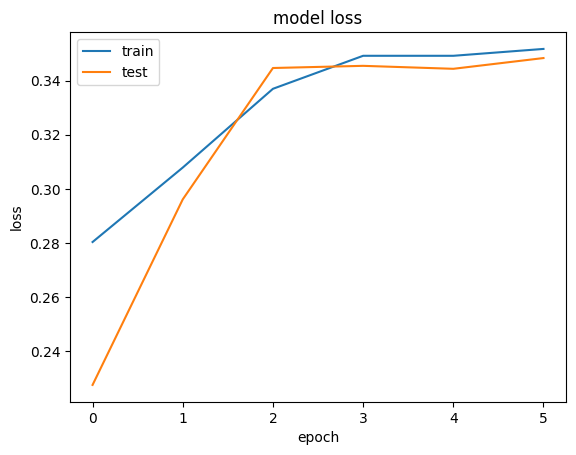

In [120]:
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 📊 Model Performance Summary

| Model               | Training Accuracy | Test Accuracy | Test Loss | Comments                             |
|--------------------|-------------------|---------------|-----------|--------------------------------------|
| **Dense + Flatten**| 90.46%            | 90.08%        | 0.253     | Strong baseline, slight overfitting |
| **CNN**            | **97.25%**        | **94.01%**    | **0.161** | Best generalization & low loss      |
| **LSTM**           | 88.06%            | 88.05%        | 0.354     | Underfitting, could be improved     |


# Saving the model and tokenizer

In [121]:
# Save model
cnn_model.save("sentiment_cnn_model.h5")

# Save tokenizer
import json
tokenizer_json = word_tokenizer.to_json()
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json))
